***
<font size=+2>ID: **AI-0009**</font><br>
<font size=+2>Submission Date: **02-04-2018**</font>
***

## Abstract:
**"2018 Data Science Bowl"**<br>
We’ve all seen people suffer from diseases like cancer, heart disease, chronic obstructive pulmonary disease, Alzheimer’s, and diabetes. Many have seen their loved ones pass away. Many lives would be transformed if cures came faster.
By automating Nucleus Detection, we could help unlock cures faster—from rare disorders to the common cold.
Identifying the cells’ Nuclei is the starting point for most analyses because most of the human body’s 30 trillion cells contain a Nucleus full of DNA, the genetic code that programs each cell. Identifying Nuclei allows researchers to identify each individual cell in a sample, and by measuring how cells react to various treatments, the researcher can understand the underlying biological processes at work.
The project will emerge as an Intelligent Program to automate the process of identifying Nuclei, which will allow for more efficient drug testing, shortening the 10 years it takes for each new drug to come to market.

## Purpose of the Assignment:
The purpose of the Assignment is to find the Nuclei in divergent images to advance medical discovery. It invovles basic OpenCV and U-Net Model. The objective is to speed up research for almost every disease, from lung cancer and heart disease to rare disorders. The 2018 Data Science Bowl offers our most ambitious mission yet: creating an algorithm to automate Nucleus Detection.
***

## 1. Dataset Analysis

In [1]:
# 2018 Data Science Bowl

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import cv2

TRAIN_PATH = '/mydata/stage1_train/'
TEST_PATH = '/mydata/stage1_test/'

# IDs' of Train and Test Images
IDtrn = os.listdir(TRAIN_PATH)
IDtst = os.listdir(TEST_PATH)

# Number of Images
print('Number of Images(Train):', len(IDtrn))
print('Number of Images(Test):', len(IDtst))

Number of Images(Train): 670
Number of Images(Test): 65


## 2. Data Preprocessing (OpenCV)

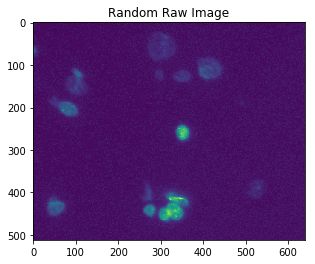

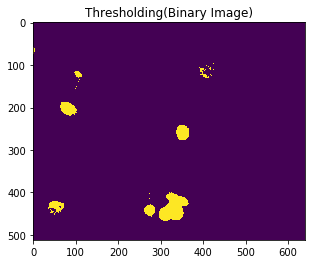

In [2]:
# Test Image Directories
TestImages = [glob.glob(os.path.join(TEST_PATH, x, 'images', '*'))[0] for x in IDtst]

# Random Image
imgp = np.random.choice(TestImages)
img = cv2.imread(imgp, cv2.IMREAD_GRAYSCALE)
plt.figure(1)
plt.title('Random Raw Image')
plt.imshow(img)
plt.show()

# Binary Matrix
ret, thresh = cv2.threshold(img, 100, 255, cv2.THRESH_OTSU)
plt.figure(2)
plt.title('Thresholding(Binary Image)')
plt.imshow(thresh)
plt.show()

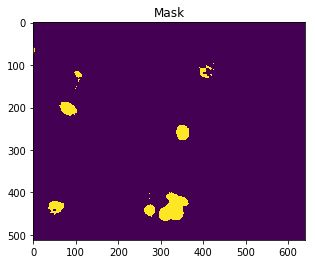

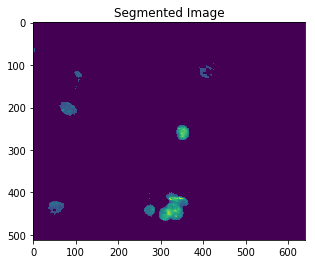

In [3]:
# Contours
im2, contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours = sorted(contours, key = cv2.contourArea, reverse = True)
cntmax = cv2.contourArea(contours[0])

# Invert Image
if(cntmax > 50000):
    ret, thresh = cv2.threshold(img, 100, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)
    
# Morphology
mask = cv2.dilate(thresh, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5)))
mask = cv2.erode(mask, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5)))
plt.figure(3)
plt.title('Mask')
plt.imshow(mask)
plt.show()

# Segmentation
segimg = cv2.bitwise_and(img, img, mask = mask)
plt.figure(4)
plt.title('Segmented Image')
plt.imshow(segimg)
plt.show()

In [4]:
# Functions to process the Images

def threshold(gray_image):
    gray_image = cv2.GaussianBlur(gray_image, (7,7), 1)
    ret, thresh = cv2.threshold(gray_image, 100, 255, cv2.THRESH_OTSU)
    
    im2, contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key = cv2.contourArea, reverse = True)
    cntmax = cv2.contourArea(contours[0])
    
    if(cntmax > 50000):
        ret, thresh = cv2.threshold(gray_image, 100, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)
    
    return thresh

def mask(thresh):
    mask = cv2.dilate(thresh, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5)))
    mask = cv2.erode(mask, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5)))
    
    return mask

In [5]:
# Test Images(Processed)
segmented = []
for imagep in TestImages:
    image = cv2.imread(imagep, cv2.IMREAD_GRAYSCALE)
    thresh = threshold(image)
    masked = mask(thresh)
    # img_seg = cv2.bitwise_and(image, image, mask = masked)
    segmented = segmented + [masked]

In [6]:
# Run Length Encoding(RLE)

from skimage.morphology import label

def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b > prev + 1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cutoff = 0.5):
    lab_img = label(x > cutoff)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)

In [7]:
# Nucleus Detection
new_test_ids = []
rles = []
for n, id_ in enumerate(IDtst):
    rle = list(prob_to_rles(segmented[n]))
    rles.extend(rle)
    new_test_ids.extend([id_] * len(rle))

In [8]:
# Submission
submission = pd.DataFrame()
submission['ImageId'] = new_test_ids
submission['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
submission.to_csv('DSB_OCV.csv', index = False)

## Approach Summary:
Test Images were preprocessed using OpenCV and then they were Run Length Encoded(RLE). No Machine Learning/Deep Learning was used so far, but still the accuracy(IoU Metrics) was 0.229 which is considerable for such simple approach.

## 3. U-Net: Convolutional Networks for Biomedical Image Segmentation

In [9]:
# Train Image Directories
TrainImages = [glob.glob(os.path.join(TRAIN_PATH, x, 'images', '*'))[0] for x in IDtrn]

# Preprocessing for Training
Xtrain = []
for imgp in TrainImages:
    img = cv2.imread(imgp)
    img = cv2.resize(img, (128, 128))
    Xtrain = Xtrain + [img]
    
Xtrain = np.asarray(Xtrain)

# Preprocessing for Test Images
Xtest = []
for imgp in TestImages:
    img = cv2.imread(imgp)
    img = cv2.resize(img, (128, 128))
    Xtest = Xtest + [img]
    
Xtest = np.asarray(Xtest)

In [10]:
# Train Masks
Ytrain = []
for i in IDtrn:
    temp = glob.glob(os.path.join(TRAIN_PATH, i, 'masks', '*'))
    mask = np.zeros((128, 128))
    for j in temp:
        mask_ = cv2.imread(j, cv2.IMREAD_GRAYSCALE)
        mask_ = cv2.resize(mask_, (128, 128))
        mask = np.maximum(mask, mask_)
    Ytrain = Ytrain + [mask]
Ytrain = np.asarray(Ytrain)

In [11]:
# Data Shapes
print('Shape of Train Data:', Xtrain.shape)
print('Shape of Train Mask:', Ytrain.shape)
print('Shape of Test Data:', Xtest.shape)

Shape of Train Data: (670, 128, 128, 3)
Shape of Train Mask: (670, 128, 128)
Shape of Test Data: (65, 128, 128, 3)


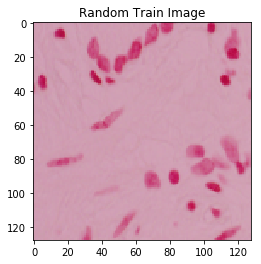

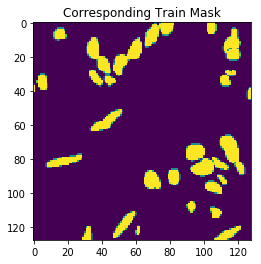

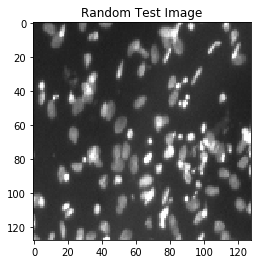

In [12]:
# Check Images
plt.figure(5)
plt.imshow(Xtrain[300])
plt.title('Random Train Image')
plt.show()

plt.figure(6)
plt.imshow(Ytrain[300])
plt.title('Corresponding Train Mask')
plt.show()

plt.figure(7)
plt.imshow(Xtest[30])
plt.title('Random Test Image')
plt.show()

In [13]:
import random
import sys
import warnings
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from keras.utils import Progbar

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose,Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras import backend as K

warnings.filterwarnings('ignore', category = UserWarning, module = 'skimage')

# Setting seed for reproducability
seed = 42
random.seed = seed
np.random.seed = seed
smooth = 1.0
epochs = 150

Using TensorFlow backend.


In [14]:
# Get train and test IDs
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

In [15]:
# Function to read Train Images and Mask and return as Numpy Array
def read_train_data(IMG_WIDTH = 256, IMG_HEIGHT = 256, IMG_CHANNELS = 3):
    X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype = np.uint8)
    Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype = np.bool)
    print('Getting and resizing Train Images and Masks ... ')
    sys.stdout.flush()
    if os.path.isfile('train_img.npy') and os.path.isfile('train_mask.npy'):
        print('Train file loaded from memory')
        X_train = np.load('train_img.npy')
        Y_train = np.load('train_mask.npy')
        return X_train, Y_train
    a = Progbar(len(train_ids))
    for n, id_ in enumerate(train_ids):
        path = TRAIN_PATH + id_
        img = imread(path + '/images/' + id_ + '.png')[:, :, :IMG_CHANNELS]
        img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode = 'constant', preserve_range = True)
        X_train[n] = img
        mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype = np.bool)
        for mask_file in next(os.walk(path + '/masks/'))[2]:
            mask_ = imread(path + '/masks/' + mask_file)
            mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode = 'constant', 
                                          preserve_range = True), axis = -1)
            mask = np.maximum(mask, mask_)
        Y_train[n] = mask
        a.update(n)
    np.save('train_img', X_train)
    np.save('train_mask', Y_train)
    return X_train, Y_train

In [16]:
# Function to read Test Images and return as Numpy Array
def read_test_data(IMG_WIDTH = 256, IMG_HEIGHT = 256, IMG_CHANNELS = 3):
    X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype = np.uint8)
    sizes_test = []
    print('\nGetting and resizing Test Images ... ')
    sys.stdout.flush()
    if os.path.isfile('test_img.npy') and os.path.isfile('test_size.npy'):
        print('Test file loaded from memory')
        X_test = np.load('test_img.npy')
        sizes_test = np.load('test_size.npy')
        return X_test, sizes_test
    b = Progbar(len(test_ids))
    for n, id_ in enumerate(test_ids):
        path = TEST_PATH + id_
        img = imread(path + '/images/' + id_ + '.png')[:, :, :IMG_CHANNELS]
        sizes_test.append([img.shape[0], img.shape[1]])
        img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode = 'constant', preserve_range = True)
        X_test[n] = img
        b.update(n)
    np.save('test_img', X_test)
    np.save('test_size', sizes_test)
    return X_test, sizes_test

In [17]:
# Run Length Encoding
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b > prev + 1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cutoff = 0.5):
    lab_img = label(x > cutoff)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)

In [18]:
# Iterate over the Test IDs and generate Run Length Encodings for each seperate Mask identified by skimage
def mask_to_rle(preds_test_upsampled):
    new_test_ids = []
    rles = []
    for n, id_ in enumerate(test_ids):
        rle = list(prob_to_rles(preds_test_upsampled[n]))
        rles.extend(rle)
        new_test_ids.extend([id_] * len(rle))
    return new_test_ids, rles

In [19]:
# Metric Function
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2.0 * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

# Loss funtion
def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [20]:
# U-net
def get_unet(IMG_WIDTH = 256, IMG_HEIGHT = 256, IMG_CHANNELS = 3):
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = Lambda(lambda x: x / 255)(inputs)
    c1 = Conv2D(16, (3, 3), activation = 'elu', kernel_initializer = 'he_normal', padding = 'same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation = 'elu', kernel_initializer = 'he_normal', padding = 'same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    c2 = Conv2D(32, (3, 3), activation = 'elu', kernel_initializer = 'he_normal', padding = 'same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation = 'elu', kernel_initializer = 'he_normal', padding = 'same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation = 'elu', kernel_initializer = 'he_normal', padding = 'same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation = 'elu', kernel_initializer = 'he_normal', padding = 'same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation = 'elu', kernel_initializer = 'he_normal', padding = 'same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation = 'elu', kernel_initializer = 'he_normal', padding = 'same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = Conv2D(256, (3, 3), activation = 'elu', kernel_initializer = 'he_normal', padding = 'same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation = 'elu', kernel_initializer = 'he_normal', padding = 'same')(c5)

    u6 = Conv2DTranspose(128, (2, 2), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation = 'elu', kernel_initializer = 'he_normal', padding = 'same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation = 'elu', kernel_initializer = 'he_normal', padding = 'same')(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation = 'elu', kernel_initializer = 'he_normal', padding = 'same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation = 'elu', kernel_initializer = 'he_normal', padding = 'same')(c7)

    u8 = Conv2DTranspose(32, (2, 2), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation = 'elu', kernel_initializer = 'he_normal', padding= 'same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation = 'elu', kernel_initializer = 'he_normal', padding = 'same')(c8)

    u9 = Conv2DTranspose(16, (2, 2), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1], axis = 3)
    c9 = Conv2D(16, (3, 3), activation = 'elu', kernel_initializer = 'he_normal', padding = 'same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation = 'elu', kernel_initializer = 'he_normal', padding = 'same')(c9)

    outputs = Conv2D(1, (1, 1), activation = 'sigmoid')(c9)

    model = Model(inputs = [inputs], outputs = [outputs])
    model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = [dice_coef])
    return model

In [21]:
# Train Data
train_img, train_mask = read_train_data()

# Test Data
test_img, test_img_sizes = read_test_data()

Getting and resizing Train Images and Masks ... 
669/670 [============================>.] - ETA: 0s
Getting and resizing Test Images ... 
64/65 [============================>.] - ETA: 0s

In [ ]:
# U_net Model
u_net = get_unet()
u_net.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 256, 256, 3)   0                                            
____________________________________________________________________________________________________
lambda_1 (Lambda)                (None, 256, 256, 3)   0           input_1[0][0]                    
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 256, 256, 16)  448         lambda_1[0][0]                   
____________________________________________________________________________________________________
dropout_1 (Dropout)              (None, 256, 256, 16)  0           conv2d_1[0][0]                   
___________________________________________________________________________________________

In [ ]:
# Fit Model on Train Data
print('\nTraining...')
u_net.fit(train_img, train_mask, batch_size = 16, epochs = epochs)


Training...
Epoch 1/150
670/670 [==============================] - 103s - loss: 0.4501 - dice_coef: 0.1927   
Epoch 2/150
670/670 [==============================] - 23s - loss: 0.2530 - dice_coef: 0.4630    
Epoch 3/150
670/670 [==============================] - 23s - loss: 0.1436 - dice_coef: 0.7197    
Epoch 4/150
670/670 [==============================] - 23s - loss: 0.1142 - dice_coef: 0.7839    
Epoch 5/150
670/670 [==============================] - 23s - loss: 0.1089 - dice_coef: 0.7911    
Epoch 6/150
670/670 [==============================] - 23s - loss: 0.1017 - dice_coef: 0.8050    
Epoch 7/150
670/670 [==============================] - 23s - loss: 0.0999 - dice_coef: 0.8117    
Epoch 8/150
670/670 [==============================] - 23s - loss: 0.0971 - dice_coef: 0.8177    
Epoch 9/150
670/670 [==============================] - 23s - loss: 0.0899 - dice_coef: 0.8295    
Epoch 10/150
670/670 [==============================] - 23s - loss: 0.0868 - dice_coef: 0.8334    
Epoch 

In [ ]:
print('Predicting')
# Predict on test data
test_mask = u_net.predict(test_img, verbose = 1)

Predicting
65/65 [==============================] - 2s     


In [ ]:
# Create list of upsampled Test Masks
test_mask_upsampled = []
for i in range(len(test_mask)):
    test_mask_upsampled.append(resize(np.squeeze(test_mask[i]),
                                     (test_img_sizes[i][0], test_img_sizes[i][1]), 
                                      mode = 'constant', preserve_range = True))

In [ ]:
test_ids, rles = mask_to_rle(test_mask_upsampled)

In [ ]:
# Submission DataFrame
sub = pd.DataFrame()
sub['ImageId'] = test_ids
sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
sub.to_csv('DSBowl2018.csv', index = False)

## Approach Summary:
U-Net is very effective in the field of Biomedical Image Segmentation. U-Net Model was used to predict the Masks of Images in Boolean Data type. The predicted Masks were then Run Length Encoded for final submission. Image size was kept 256 X 256 with Train Images of 3 channels and Masks of 1 channel. There were multiple Masks for a single Image each representing a single Neucleus. They were overlapped to get the complete Mask of an Image. 150 epochs were run with batch size 16 which resulted in a considerable Accuracy.

## Result:

In [ ]:
sub.head(5)

,ImageId,EncodedPixels
0,1962d0c5faf3e85cda80e0578e0cb7aca50826d781620e...,1 11 520 12 1039 12 1558 13 2077 14 2596 15 31...
1,1962d0c5faf3e85cda80e0578e0cb7aca50826d781620e...,22319 2 22837 4 23356 4 23875 5 24394 5 24913 ...
2,1962d0c5faf3e85cda80e0578e0cb7aca50826d781620e...,67990 5 68509 7 69028 8 69547 8 70066 8 70585 ...
3,1962d0c5faf3e85cda80e0578e0cb7aca50826d781620e...,31671 10 32189 14 32708 16 33226 19 33744 20 3...
4,1962d0c5faf3e85cda80e0578e0cb7aca50826d781620e...,22332 13 22850 16 23368 21 23886 23 24405 23 2...


**Kaggle Score(IoU):** 0.316

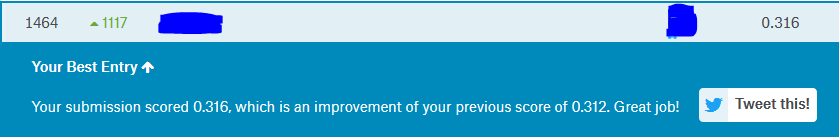

In [1]:
# Kaggle Score(Screen Shot)
from IPython.display import Image
Image('Kaggle.PNG')

## Discussion:
Two basic approaches were implemented in this project. However, Mask-RCNN could incredibly improve the accuracy. It is kept for future improvement.